This notebook contains the code for the meta-analysis of healthy lung data for ACE2, TMPRSS2, and CTSL. It contains the hold-out analysis for the simple model without interaction terms that was run on the cell-level data. This script contains the code that was run on the full data and does not test for smoking associations.

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import colors
from matplotlib import patches
import seaborn as sns
import batchglm
import diffxpy.api as de
import patsy as pat
from statsmodels.stats.multitest import multipletests
import logging, warnings
import statsmodels.api as sm

/home/icb/malte.luecken/anaconda3/envs/cov19_py/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()
de.__version__

logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

pd.set_option('display.max_rows', 655)
pd.set_option('display.max_columns', 35)
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


'v0.7.3'

In [3]:
#User inputs
folder = '/storage/groups/ml01/workspace/malte.luecken/2020_cov19_study'

adata_diffxpy = '/storage/groups/ml01/workspace/malte.luecken/2020_cov19_study/COVID19_lung_atlas_revision_v3.h5ad'

output_folder = 'diffxpy_out/'

de_output_base = 'COVID19_lung_atlas_revision_v3_lung_cov19_poissonglm_holdouts_nUMIoffset_noInts'

# Read the data

In [4]:
adata = sc.read(adata_diffxpy)

In [5]:
adata

AnnData object with n_obs × n_vars = 1320896 × 3 
    obs: 'age', 'anatomical_region', 'donor', 'last_author/PI', 'lung_vs_nasal', 'notes', 'original_celltype_ann', 'sample', 'sex', 'smoking', 'total_counts', 'smoked_boolean', 'last_author_sample_name', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new'

In [6]:
adata.obs.age = adata.obs.age.astype(float)

In [7]:
adata.obs.dtypes

age                         float64
anatomical_region          category
donor                      category
last_author/PI             category
lung_vs_nasal              category
notes                      category
original_celltype_ann      category
sample                     category
sex                        category
smoking                    category
total_counts                float64
smoked_boolean             category
last_author_sample_name    category
ann_level_1                category
ann_level_2                category
ann_level_3                category
ann_level_4                category
ann_level_5                category
ann_highest_res               int64
ann_new                        bool
dtype: object

In [8]:
adata.obs['dataset'] = adata.obs['last_author/PI']

In [9]:
adata.obs.dataset.value_counts()

Regev/Rajagopal            322998
Meyer_b                    117535
Kaminski                    95303
Spence                      78401
Barbry/Leroy                76981
Krasnow/Quake               60993
Meyer                       57020
Rawlins                     53409
Regev                       43527
Misharin/Budinger           41266
Eils/Conrad/Kreuter         39778
Seibold                     36248
Whitsett/Xu_10X             34185
Koenigshoff                 33119
Misharin                    28329
Xavier/Regev                25552
Spira/Campbell              24455
Lafyatis/Rojas              24220
Kropski/Banovich_vand       23285
Schultze                    22641
Schiller                    20776
Nawijn                      18197
Teichmann                   12971
Kropski/Banovich_dnar        8359
Shalek                       7603
Linnarsson                   4640
Whitsett/Xu_dropSeq          3267
Mazzilli/Campbell/Beane      2207
Schultze/Falk                1965
Beane         

# Filter the data

Keep only datsets with:
- more than 1 donor
- non-fetal
- lung

In [10]:
# Remove fetal datasets
dats_to_remove = set(['Rawlins', 'Spence', 'Linnarsson'])

In [11]:
dat = adata.obs.groupby(['donor']).agg({'sex':'first', 'age':'first', 'dataset':'first'})

# Single donor filter
don_tab = dat['dataset'].value_counts()
dats_to_remove.update(set(don_tab.index[don_tab == 1]))

In [12]:
dats_to_remove = list(dats_to_remove)
dats_to_remove

['Linnarsson', 'Schultze/Falk', 'Misharin', 'Spence', 'Rawlins']

In [13]:
adata = adata[~adata.obs.dataset.isin(dats_to_remove)].copy()

In [14]:
adata.obs.lung_vs_nasal.value_counts()

lung     1096604
nasal      57548
Name: lung_vs_nasal, dtype: int64

In [15]:
# Filter for only lung data
adata = adata[adata.obs.lung_vs_nasal.isin(['lung']),].copy()

In [16]:
adata

AnnData object with n_obs × n_vars = 1096604 × 3 
    obs: 'age', 'anatomical_region', 'donor', 'last_author/PI', 'lung_vs_nasal', 'notes', 'original_celltype_ann', 'sample', 'sex', 'smoking', 'total_counts', 'smoked_boolean', 'last_author_sample_name', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'dataset'

In [17]:
adata.obs.dataset.value_counts()
adata.obs['sample'].nunique()
adata.obs['donor'].nunique()

Regev/Rajagopal            322998
Meyer_b                    117535
Kaminski                    95303
Krasnow/Quake               60993
Barbry/Leroy                58790
Meyer                       57020
Regev                       43527
Misharin/Budinger           41266
Eils/Conrad/Kreuter         39778
Seibold                     36248
Whitsett/Xu_10X             34185
Koenigshoff                 33119
Xavier/Regev                25552
Lafyatis/Rojas              24220
Kropski/Banovich_vand       23285
Schultze                    22641
Schiller                    20776
Teichmann                   12971
Nawijn                      11110
Kropski/Banovich_dnar        8359
Whitsett/Xu_dropSeq          3267
Mazzilli/Campbell/Beane      1995
Beane                         886
Beane/Campbell                780
Name: dataset, dtype: int64

309

185

# Check the data

In [18]:
np.mean(adata.X.astype(int) != adata.X)

0.0

In [19]:
# Check if any non-integer data in a particular dataset
for dat in adata.obs.dataset.unique():
    val = np.mean(adata[adata.obs.dataset.isin([dat]),:].X.astype(int) != adata[adata.obs.dataset.isin([dat]),:].X)
    if val != 0:
        print(f'dataset= {dat}; value= {val}')
        adata[adata.obs.dataset.isin([dat]),:].X[:20,:20].A

All counts are integers

# Fit models and perform DE

In [20]:
cluster_key = 'ann_level_2'
clust_tbl = adata.obs[cluster_key].value_counts()
clusters = clust_tbl.index[clust_tbl > 1000]
ct_to_rm = clusters[[ct.startswith('1') for ct in clusters]]
clusters = clusters.drop(ct_to_rm.tolist()).tolist()
clusters

['Myeloid',
 'Airway epithelium',
 'Alveolar epithelium',
 'Lymphoid',
 'Fibroblast lineage',
 'Blood vessels',
 'Submucosal Gland',
 'Smooth Muscle',
 'Lymphatics',
 'Mesothelium',
 'Endothelial-like',
 'Granulocytes']

Calculate DE genes per cluster.

In [21]:
adata

AnnData object with n_obs × n_vars = 1096604 × 3 
    obs: 'age', 'anatomical_region', 'donor', 'last_author/PI', 'lung_vs_nasal', 'notes', 'original_celltype_ann', 'sample', 'sex', 'smoking', 'total_counts', 'smoked_boolean', 'last_author_sample_name', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'dataset'

In [22]:
adata.obs['total_counts_scaled'] = adata.obs['total_counts']/adata.obs['total_counts'].mean()

In [23]:
formula = "1 + sex + age + dataset"
tested_coef = ["sex[T.male]", "age"]
dmat = de.utils.design_matrix(
    data=adata,
    formula="~" + formula,
    as_numeric=["age"],
    return_type="patsy"
)
dmat[1]

['Intercept',
 'sex[T.male]',
 'dataset[T.Beane]',
 'dataset[T.Beane/Campbell]',
 'dataset[T.Eils/Conrad/Kreuter]',
 'dataset[T.Kaminski]',
 'dataset[T.Koenigshoff]',
 'dataset[T.Krasnow/Quake]',
 'dataset[T.Kropski/Banovich_dnar]',
 'dataset[T.Kropski/Banovich_vand]',
 'dataset[T.Lafyatis/Rojas]',
 'dataset[T.Mazzilli/Campbell/Beane]',
 'dataset[T.Meyer]',
 'dataset[T.Meyer_b]',
 'dataset[T.Misharin/Budinger]',
 'dataset[T.Nawijn]',
 'dataset[T.Regev]',
 'dataset[T.Regev/Rajagopal]',
 'dataset[T.Schiller]',
 'dataset[T.Schultze]',
 'dataset[T.Seibold]',
 'dataset[T.Teichmann]',
 'dataset[T.Whitsett/Xu_10X]',
 'dataset[T.Whitsett/Xu_dropSeq]',
 'dataset[T.Xavier/Regev]',
 'age']

## Poisson GLM

In [24]:
# Poisson GLM loop
de_results_lvl2_glm = dict()

# Test over clusters
for clust in clusters:
    res_list = []
    
    adata_tmp = adata[adata.obs[cluster_key] == clust,:]

    hold_outs = np.unique(adata_tmp.obs["dataset"].values)
    for ho in hold_outs:
        
        adata_tmp_ho = adata_tmp[~adata_tmp.obs.dataset.isin([ho]),:].copy()    

        print(f'Holdout {ho} in cluster {clust}:')

        print(adata_tmp_ho.obs['sex'].value_counts())

        # Filter out genes to reduce multiple testing burden
        sc.pp.filter_genes(adata_tmp_ho, min_cells=10)
        if adata_tmp_ho.n_vars == 0:
            print('No genes expressed in more than 10 cells!')
            continue
        if len(adata_tmp_ho.obs.sex.value_counts())==1:
            print(f'{clust} only has 1 type of male/female sample.')
            continue
        
        print(f'Testing {adata_tmp_ho.n_vars} genes...')
        print("")
        
        # List to store results
        de_results_list = []        
        
        # Set up design matrix
        dmat = de.utils.design_matrix(
            data=adata_tmp_ho, #[idx_train],
            formula="~" + formula,
            as_numeric=["age"],
            return_type="patsy"
        )
        
        # Test if model is full rank
        if np.linalg.matrix_rank(np.asarray(dmat[0])) < np.min(dmat[0].shape):
            print(f'Cannot test {clust} as design matrix is not full rank.')
            continue
        
        for i, gene in enumerate(adata_tmp_ho.var_names):
            # Specify model
            pois_model = sm.GLM(
                endog=adata_tmp_ho.X[:, i].todense(), #[idx_train, :], 
                exog=dmat[0], 
                offset=np.log(adata_tmp_ho.obs['total_counts_scaled'].values),
                family=sm.families.Poisson()
            )
            
            # Fit the model
            pois_results = pois_model.fit()
            
            
            # Test over coefs
            for coef in tested_coef:
                de_results_temp = pois_results.wald_test(
                    [x for i, x in enumerate(pois_model.exog_names) if dmat[1][i] in [coef]]
                )

                # Output the results nicely
                de_results_temp = pd.DataFrame({
                    "gene": gene,
                    "cell_identity": clust,
                    "covariate": coef,
                    "holdout": ho,
                    "coef": pois_results.params[[y == coef for y in dmat[1]]],
                    "coef_sd": pois_results.bse[[y == coef for y in dmat[1]]],                                                   "pval": de_results_temp.pvalue
                }, index= [clust+"_"+gene+"_"+coef])

                de_results_list.append(de_results_temp)
            
        de_results = pd.concat(de_results_list)
        de_results['adj_pvals'] = multipletests(de_results['pval'].tolist(), method='fdr_bh')[1]
        res_list.append(de_results)

    # Store the results
    if len(res_list) > 0:
        de_results_lvl2_glm[clust] = pd.concat(res_list, ignore_index=True)
    
# Join the dataframes:
full_res_lvl2_glm = pd.concat([de_results_lvl2_glm[i] for i in de_results_lvl2_glm.keys()], ignore_index=True)

Holdout Barbry/Leroy in cluster Myeloid:
male      151528
female    128460
Name: sex, dtype: int64
Testing 3 genes...

Holdout Beane in cluster Myeloid:
male      152511
female    130918
Name: sex, dtype: int64
Testing 3 genes...

Holdout Eils/Conrad/Kreuter in cluster Myeloid:
male      151067
female    124866
Name: sex, dtype: int64
Testing 3 genes...

Holdout Kaminski in cluster Myeloid:
male      112046
female     97656
Name: sex, dtype: int64
Testing 3 genes...

Holdout Krasnow/Quake in cluster Myeloid:
male      140303
female    123230
Name: sex, dtype: int64
Testing 3 genes...

Holdout Kropski/Banovich_dnar in cluster Myeloid:
male      149733
female    129810
Name: sex, dtype: int64
Testing 3 genes...

Holdout Kropski/Banovich_vand in cluster Myeloid:
male      144137
female    127774
Name: sex, dtype: int64
Testing 3 genes...

Holdout Lafyatis/Rojas in cluster Myeloid:
male      146545
female    123637
Name: sex, dtype: int64
Testing 3 genes...

Holdout Mazzilli/Campbell/Beane

Holdout Kaminski in cluster Lymphoid:
female    78580
male      50458
Name: sex, dtype: int64
Testing 3 genes...

Holdout Krasnow/Quake in cluster Lymphoid:
female    80655
male      51780
Name: sex, dtype: int64
Testing 3 genes...

Holdout Kropski/Banovich_dnar in cluster Lymphoid:
female    85347
male      56585
Name: sex, dtype: int64
Testing 3 genes...

Holdout Kropski/Banovich_vand in cluster Lymphoid:
female    82631
male      56306
Name: sex, dtype: int64
Testing 3 genes...

Holdout Lafyatis/Rojas in cluster Lymphoid:
female    82515
male      55078
Name: sex, dtype: int64
Testing 3 genes...

Holdout Mazzilli/Campbell/Beane in cluster Lymphoid:
female    85199
male      56879
Name: sex, dtype: int64
Testing 3 genes...

Holdout Meyer in cluster Lymphoid:
female    66865
male      49655
Name: sex, dtype: int64
Testing 3 genes...

Holdout Meyer_b in cluster Lymphoid:
female    73604
male      38768
Name: sex, dtype: int64
Testing 3 genes...

Holdout Misharin/Budinger in cluster Lym

Holdout Meyer in cluster Lymphatics:
female    3040
male      2772
Name: sex, dtype: int64
Testing 3 genes...

Holdout Meyer_b in cluster Lymphatics:
female    2241
male      2107
Name: sex, dtype: int64
Testing 3 genes...

Holdout Misharin/Budinger in cluster Lymphatics:
female    3082
male      2845
Name: sex, dtype: int64
Testing 3 genes...

Holdout Regev in cluster Lymphatics:
female    3016
male      2672
Name: sex, dtype: int64
Testing 3 genes...

Holdout Schiller in cluster Lymphatics:
female    3201
male      2650
Name: sex, dtype: int64
Testing 3 genes...

Holdout Teichmann in cluster Lymphatics:
female    3188
male      2817
Name: sex, dtype: int64
Testing 3 genes...

Holdout Xavier/Regev in cluster Lymphatics:
female    3264
male      2484
Name: sex, dtype: int64
Testing 3 genes...

Holdout Kaminski in cluster Mesothelium:
female    1581
male       873
Name: sex, dtype: int64
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Krasnow/Qua

## Inspect some results

In [25]:
de_results_lvl2_glm.keys()

dict_keys(['Myeloid', 'Airway epithelium', 'Alveolar epithelium', 'Lymphoid', 'Fibroblast lineage', 'Blood vessels', 'Submucosal Gland', 'Smooth Muscle', 'Lymphatics', 'Mesothelium', 'Granulocytes'])

In [26]:
full_res_lvl2_glm = full_res_lvl2_glm.sort_values(by=['gene', 'cell_identity', 'covariate'])
full_res_lvl2_glm

,gene,cell_identity,covariate,holdout,coef,coef_sd,pval,adj_pvals
115,ACE2,Airway epithelium,age,Barbry/Leroy,0.003356,0.001064,1.608445e-03,2.412667e-03
121,ACE2,Airway epithelium,age,Beane,0.003469,0.001061,1.072214e-03,1.608321e-03
127,ACE2,Airway epithelium,age,Beane/Campbell,0.003540,0.001063,8.667319e-04,1.300098e-03
133,ACE2,Airway epithelium,age,Eils/Conrad/Kreuter,0.003400,0.001058,1.318152e-03,1.977228e-03
139,ACE2,Airway epithelium,age,Kaminski,0.003400,0.001060,1.334660e-03,2.001990e-03
...,...,...,...,...,...,...,...,...
662,TMPRSS2,Submucosal Gland,sex[T.male],Krasnow/Quake,0.322397,0.024185,1.537063e-40,9.222377e-40
668,TMPRSS2,Submucosal Gland,sex[T.male],Meyer_b,0.296506,0.024519,1.152236e-33,6.913414e-33
674,TMPRSS2,Submucosal Gland,sex[T.male],Nawijn,0.310527,0.024037,3.528519e-38,2.117111e-37
680,TMPRSS2,Submucosal Gland,sex[T.male],Regev/Rajagopal,0.160900,0.058783,6.196533e-03,1.239307e-02


In [27]:
full_res_lvl2_glm.loc[(full_res_lvl2_glm['gene'] == 'ACE2') & (full_res_lvl2_glm['adj_pvals'] < 0.05),]

,gene,cell_identity,covariate,holdout,coef,coef_sd,pval,adj_pvals
115,ACE2,Airway epithelium,age,Barbry/Leroy,0.003356,0.001064,1.608445e-03,2.412667e-03
121,ACE2,Airway epithelium,age,Beane,0.003469,0.001061,1.072214e-03,1.608321e-03
127,ACE2,Airway epithelium,age,Beane/Campbell,0.003540,0.001063,8.667319e-04,1.300098e-03
133,ACE2,Airway epithelium,age,Eils/Conrad/Kreuter,0.003400,0.001058,1.318152e-03,1.977228e-03
139,ACE2,Airway epithelium,age,Kaminski,0.003400,0.001060,1.334660e-03,2.001990e-03
145,ACE2,Airway epithelium,age,Koenigshoff,0.003372,0.001056,1.412126e-03,2.118189e-03
151,ACE2,Airway epithelium,age,Krasnow/Quake,0.003564,0.001061,7.832805e-04,1.174921e-03
157,ACE2,Airway epithelium,age,Kropski/Banovich_dnar,0.003369,0.001057,1.430620e-03,2.145930e-03
163,ACE2,Airway epithelium,age,Kropski/Banovich_vand,0.003327,0.001059,1.679094e-03,2.518641e-03
169,ACE2,Airway epithelium,age,Lafyatis/Rojas,0.003450,0.001059,1.126691e-03,1.690036e-03


### Aggregate hold-out results statistics

In [28]:
def prop_signif(series):
    return (series < 0.05).mean()

def prop_pos(series):
    return (series > 0).mean()

def prop_pos_zero(series):
    return (series >= 0).mean()

def prop_neg_zero(series):
    return (series <= 0).mean()


In [29]:
res_summary_lvl2 = full_res_lvl2_glm.groupby(['gene', 'cell_identity', 'covariate']).agg({
    'adj_pvals':prop_signif,
    'coef':['mean', 'std', prop_pos],
    'holdout':'count'
}).reset_index()

res_summary_lvl2

gene        cell_identity    covariate   adj_pvals      coef            \
                                              prop_signif      mean       std   
0      ACE2    Airway epithelium          age    1.000000  0.003231  0.002174   
1      ACE2    Airway epithelium  sex[T.male]    0.083333  0.067301  0.021040   
2      ACE2  Alveolar epithelium          age    0.944444  0.014044  0.003654   
3      ACE2  Alveolar epithelium  sex[T.male]    1.000000  0.806426  0.075165   
4      ACE2        Blood vessels          age    0.000000 -0.006792  0.009299   
5      ACE2        Blood vessels  sex[T.male]    0.846154  2.564716  5.426436   
6      ACE2   Fibroblast lineage          age    0.000000  0.004264  0.001983   
7      ACE2   Fibroblast lineage  sex[T.male]    0.000000  0.042003  0.049586   
8      ACE2           Lymphatics          age    1.000000  0.068042  0.006532   
9      ACE2           Lymphatics  sex[T.male]    0.166667  1.395114  0.110656   
10     ACE2             Lymphoid          age    0.900000 -0.028219  0.002325   
11     ACE2             Lymphoid  sex[T.male]    0.000000  0.310842  0.077019   
12     ACE2              Myeloid          age    0.000000  0.001116  0.002546   
13     ACE2              Myeloid  sex[T.male]    0.894737  0.551560  0.174991   
14     ACE2        Smooth Muscle          age    0.000000 -0.001993  0.010530   
15     ACE2        Smooth Muscle  sex[T.male]    0.000000  0.210839  0.159979   
16     ACE2     Submucosal Gland          age    0.833333  0.005008  0.001142   
17     ACE2     Submucosal Gland  sex[T.male]    0.000000  0.004072  0.041642   
18     CTSL    Airway epithelium          age    1.000000  0.003872  0.000225   
19     CTSL    Airway epithelium  sex[T.male]    1.000000 -0.125150  0.018760   
20     CTSL  Alveolar epithelium          age    1.000000 -0.004778  0.000752   
21     CTSL  Alveolar epithelium  sex[T.male]    1.000000  0.146503  0.013556   
22     CTSL        Blood vessels          age    0.153846  0.001326  0.000601   
23     CTSL        Blood vessels  sex[T.male]    0.923077  0.078454  0.025329   
24     CTSL   Fibroblast lineage          age    1.000000 -0.015238  0.001891   
25     CTSL   Fibroblast lineage  sex[T.male]    1.000000 -0.335126  0.101277   
26     CTSL         Granulocytes          age    0.000000 -0.099290  0.110620   
27     CTSL         Granulocytes  sex[T.male]    0.000000  0.764164  0.713089   
28     CTSL           Lymphatics          age    0.923077  0.004556  0.000565   
29     CTSL           Lymphatics  sex[T.male]    0.000000  0.012875  0.012866   
30     CTSL             Lymphoid          age    1.000000  0.006235  0.005597   
31     CTSL             Lymphoid  sex[T.male]    1.000000  0.380323  0.060337   
32     CTSL          Mesothelium          age    0.000000 -0.001137  0.005759   
33     CTSL          Mesothelium  sex[T.male]    0.857143  0.363116  0.235837   
34     CTSL              Myeloid          age    1.000000 -0.001012  0.001080   
35     CTSL              Myeloid  sex[T.male]    1.000000 -0.100689  0.040447   
36     CTSL        Smooth Muscle          age    1.000000 -0.011222  0.000781   
37     CTSL        Smooth Muscle  sex[T.male]    1.000000 -0.390945  0.079201   
38     CTSL     Submucosal Gland          age    0.833333  0.006475  0.003122   
39     CTSL     Submucosal Gland  sex[T.male]    0.833333 -0.088702  0.033533   
40  TMPRSS2    Airway epithelium          age    0.125000  0.000248  0.001706   
41  TMPRSS2    Airway epithelium  sex[T.male]    1.000000  0.188709  0.021919   
42  TMPRSS2  Alveolar epithelium          age    1.000000  0.021280  0.004846   
43  TMPRSS2  Alveolar epithelium  sex[T.male]    0.944444  0.094483  0.046856   
44  TMPRSS2        Blood vessels          age    0.000000 -0.001483  0.005999   
45  TMPRSS2        Blood vessels  sex[T.male]    0.000000  0.232478  0.092390   
46  TMPRSS2   Fibroblast lineage          age    0.933333  0.008170  0.005282   
47  TMPRSS2   Fibroblast lineage  sex[

# Level 3 annotation

In [30]:
cluster_key = 'ann_level_3'
clust_tbl = adata.obs[cluster_key].value_counts()
clusters = clust_tbl.index[clust_tbl > 1000]
ct_to_rm = clusters[[ct.startswith('1') or ct.startswith('2') for ct in clusters]]
clusters = clusters.drop(ct_to_rm.tolist()).tolist()
clusters

['Macrophages',
 'AT2',
 'Basal',
 'T cell lineage',
 'Monocytes',
 'Multiciliated lineage',
 'AT1',
 'Submucosal Secretory',
 'Innate lymphoid cells',
 'Secretory',
 'Capillary',
 'Mast cells',
 'B cell lineage',
 'Fibroblasts',
 'Dendritic cells',
 'Venous',
 'Lymphatic EC',
 'Arterial',
 'Rare',
 'Myofibroblasts',
 'MDC',
 'Airway smooth muscle']

In [31]:
adata_sub = adata[adata.obs.ann_level_3.isin(clusters),:]

adata_sub
adata_sub.obs.donor.nunique()
adata_sub.obs['sample'].nunique()

View of AnnData object with n_obs × n_vars = 895743 × 3 
    obs: 'age', 'anatomical_region', 'donor', 'last_author/PI', 'lung_vs_nasal', 'notes', 'original_celltype_ann', 'sample', 'sex', 'smoking', 'total_counts', 'smoked_boolean', 'last_author_sample_name', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'dataset', 'total_counts_scaled'

185

309

## Poisson GLM

In [32]:
# Poisson GLM loop
de_results_lvl3_glm = dict()

# Test over clusters
for clust in clusters:
    res_list = []
    
    adata_tmp = adata_sub[adata_sub.obs[cluster_key] == clust,:]

    hold_outs = np.unique(adata_tmp.obs["dataset"].values)
    for ho in hold_outs:
        
        adata_tmp_ho = adata_tmp[~adata_tmp.obs.dataset.isin([ho]),:].copy()    

        print(f'Holdout {ho} in cluster {clust}:')

        print(adata_tmp_ho.obs['sex'].value_counts())

        # Filter out genes to reduce multiple testing burden
        sc.pp.filter_genes(adata_tmp_ho, min_cells=10)
        if adata_tmp_ho.n_vars == 0:
            print('No genes expressed in more than 10 cells!')
            continue
        if len(adata_tmp_ho.obs.sex.value_counts())==1:
            print(f'{clust} only has 1 type of male/female sample.')
            continue
        
        print(f'Testing {adata_tmp_ho.n_vars} genes...')
        print("")
        
        # List to store results
        de_results_list = []        
        
        # Set up design matrix
        dmat = de.utils.design_matrix(
            data=adata_tmp_ho,
            formula="~" + formula,
            as_numeric=["age"],
            return_type="patsy"
        )
        
        # Test if model is full rank
        if np.linalg.matrix_rank(np.asarray(dmat[0])) < np.min(dmat[0].shape):
            print(f'Cannot test {clust} as design matrix is not full rank.')
            continue
        
        for i, gene in enumerate(adata_tmp_ho.var_names):
            # Specify model
            pois_model = sm.GLM(
                endog=adata_tmp_ho.X[:, i].todense(),
                exog=dmat[0],
                offset=np.log(adata_tmp_ho.obs['total_counts_scaled'].values),
                family=sm.families.Poisson()
            )
            
            # Fit the model
            pois_results = pois_model.fit()
            
            
            # Test over coefs
            for coef in tested_coef:
                de_results_temp = pois_results.wald_test(
                    [x for i, x in enumerate(pois_model.exog_names) if dmat[1][i] in [coef]]
                )

                # Output the results nicely
                de_results_temp = pd.DataFrame({
                    "gene": gene,
                    "cell_identity": clust,
                    "covariate": coef,
                    "holdout": ho,
                    "coef": pois_results.params[[y == coef for y in dmat[1]]],
                    "coef_sd": pois_results.bse[[y == coef for y in dmat[1]]],                    
                    "pval": de_results_temp.pvalue
                }, index= [clust+"_"+gene+"_"+coef])

                de_results_list.append(de_results_temp)
            
        de_results = pd.concat(de_results_list)
        de_results['adj_pvals'] = multipletests(de_results['pval'].tolist(), method='fdr_bh')[1]
        res_list.append(de_results)

    # Store the results
    if len(res_list) > 0:
        de_results_lvl3_glm[clust] = pd.concat(res_list, ignore_index=True)
    
# Join the dataframes:
full_res_lvl3_glm = pd.concat([de_results_lvl3_glm[i] for i in de_results_lvl3_glm.keys()], ignore_index=True)

Holdout Barbry/Leroy in cluster Macrophages:
male      113577
female     73067
Name: sex, dtype: int64
Testing 3 genes...

Holdout Kaminski in cluster Macrophages:
male      77466
female    46853
Name: sex, dtype: int64
Testing 3 genes...

Holdout Krasnow/Quake in cluster Macrophages:
male      104055
female     69377
Name: sex, dtype: int64
Testing 3 genes...

Holdout Kropski/Banovich_dnar in cluster Macrophages:
male      112719
female     74233
Name: sex, dtype: int64
Testing 3 genes...

Holdout Kropski/Banovich_vand in cluster Macrophages:
male      105900
female     72886
Name: sex, dtype: int64
Testing 3 genes...

Holdout Lafyatis/Rojas in cluster Macrophages:
male      108846
female     69805
Name: sex, dtype: int64
Testing 3 genes...

Holdout Meyer in cluster Macrophages:
male      110826
female     72602
Name: sex, dtype: int64
Testing 3 genes...

Holdout Meyer_b in cluster Macrophages:
male      91102
female    71173
Name: sex, dtype: int64
Testing 3 genes...

Holdout Mishari

Holdout Kropski/Banovich_vand in cluster Monocytes:
male      21600
female    20688
Name: sex, dtype: int64
Testing 3 genes...

Holdout Lafyatis/Rojas in cluster Monocytes:
male      21211
female    20180
Name: sex, dtype: int64
Testing 3 genes...

Holdout Meyer in cluster Monocytes:
male      18895
female    18531
Name: sex, dtype: int64
Testing 3 genes...

Holdout Meyer_b in cluster Monocytes:
female    19604
male      13599
Name: sex, dtype: int64
Testing 3 genes...

Holdout Misharin/Budinger in cluster Monocytes:
male      21573
female    20607
Name: sex, dtype: int64
Testing 3 genes...

Holdout Nawijn in cluster Monocytes:
male      21695
female    21692
Name: sex, dtype: int64
Testing 3 genes...

Holdout Schultze in cluster Monocytes:
male      21654
female    21627
Name: sex, dtype: int64
Testing 3 genes...

Holdout Teichmann in cluster Monocytes:
female    20455
male      20289
Name: sex, dtype: int64
Testing 3 genes...

Holdout Xavier/Regev in cluster Monocytes:
female    2169

Testing 2 genes...

Holdout Regev in cluster Innate lymphoid cells:
female    17840
male      13082
Name: sex, dtype: int64
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Schiller in cluster Innate lymphoid cells:
female    17547
male      12682
Name: sex, dtype: int64
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Schultze in cluster Innate lymphoid cells:
female    17895
male      13180
Name: sex, dtype: int64
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Barbry/Leroy in cluster Secretory:
male      10745
female     6614
Name: sex, dtype: int64
Testing 3 genes...

Holdout Beane in cluster Secretory:
male      14484
female    11326
Name: sex, dtype: int64
Testing 3 genes...

Holdout Beane/Campbell in cluster Secretory:
male      14476
female    11198
Name: sex, dtype: int64
Testing 3 genes...

Holdout Eils/Conrad/Kreuter in cluster Secretory:
male      14171
f

Testing 2 genes...

Holdout Nawijn in cluster B cell lineage:
female    6896
male      5487
Name: sex, dtype: int64
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Regev in cluster B cell lineage:
female    6910
male      5513
Name: sex, dtype: int64
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Regev/Rajagopal in cluster B cell lineage:
male      4758
female    3728
Name: sex, dtype: int64
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Schiller in cluster B cell lineage:
female    6759
male      5239
Name: sex, dtype: int64
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Teichmann in cluster B cell lineage:
female    6917
male      5484
Name: sex, dtype: int64
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Xavier/Regev in cluster B cell lineage:
female    6932
male      5462
Name

Holdout Beane in cluster Rare:
male      1479
female    1176
Name: sex, dtype: int64
Testing 3 genes...

Holdout Beane/Campbell in cluster Rare:
male      1477
female    1186
Name: sex, dtype: int64
Testing 3 genes...

Holdout Kaminski in cluster Rare:
male      1480
female    1177
Name: sex, dtype: int64
Testing 3 genes...

Holdout Koenigshoff in cluster Rare:
male      1485
female    1186
Name: sex, dtype: int64
Testing 3 genes...

Holdout Krasnow/Quake in cluster Rare:
male      1488
female    1155
Name: sex, dtype: int64
Testing 3 genes...

Holdout Meyer_b in cluster Rare:
male      1467
female    1149
Name: sex, dtype: int64
Testing 3 genes...

Holdout Nawijn in cluster Rare:
male      1438
female    1186
Name: sex, dtype: int64
Testing 3 genes...

Holdout Regev/Rajagopal in cluster Rare:
male      379
female    286
Name: sex, dtype: int64
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Seibold in cluster Rare:
male      1306
female    1090

## Inspect some results

In [33]:
de_results_lvl3_glm.keys()

dict_keys(['Macrophages', 'AT2', 'Basal', 'T cell lineage', 'Monocytes', 'Multiciliated lineage', 'AT1', 'Submucosal Secretory', 'Innate lymphoid cells', 'Secretory', 'Capillary', 'Mast cells', 'B cell lineage', 'Fibroblasts', 'Dendritic cells', 'Venous', 'Lymphatic EC', 'Arterial', 'Rare', 'Myofibroblasts', 'Airway smooth muscle'])

In [34]:
full_res_lvl3_glm = full_res_lvl3_glm.sort_values(by=['gene', 'cell_identity', 'covariate'])


In [35]:
full_res_lvl3_glm.loc[full_res_lvl3_glm['gene'] == 'ACE2']

,gene,cell_identity,covariate,holdout,coef,coef_sd,pval,adj_pvals
599,ACE2,AT1,age,Barbry/Leroy,0.014541,0.005878,1.336652e-02,1.336652e-02
605,ACE2,AT1,age,Eils/Conrad/Kreuter,0.013494,0.006461,3.674630e-02,3.674630e-02
611,ACE2,AT1,age,Kaminski,0.017263,0.005936,3.636357e-03,3.636357e-03
617,ACE2,AT1,age,Koenigshoff,0.014541,0.005878,1.336652e-02,1.336652e-02
623,ACE2,AT1,age,Krasnow/Quake,0.014712,0.005879,1.233209e-02,1.233209e-02
629,ACE2,AT1,age,Kropski/Banovich_dnar,0.014541,0.005878,1.336652e-02,1.336652e-02
635,ACE2,AT1,age,Kropski/Banovich_vand,0.014633,0.005884,1.287881e-02,1.287881e-02
641,ACE2,AT1,age,Lafyatis/Rojas,0.014541,0.005878,1.336652e-02,1.336652e-02
647,ACE2,AT1,age,Meyer,0.014193,0.005907,1.626130e-02,1.626130e-02
653,ACE2,AT1,age,Meyer_b,0.014342,0.005913,1.528026e-02,1.528026e-02


In [36]:
full_res_lvl3_glm.loc[full_res_lvl3_glm['gene'] == 'TMPRSS2']

,gene,cell_identity,covariate,holdout,coef,coef_sd,pval,adj_pvals
601,TMPRSS2,AT1,age,Barbry/Leroy,0.011628,0.000694,4.967854e-63,1.490356e-62
607,TMPRSS2,AT1,age,Eils/Conrad/Kreuter,0.016859,0.000807,6.389191e-97,1.916757e-96
613,TMPRSS2,AT1,age,Kaminski,0.012015,0.000704,2.597917e-65,7.793752e-65
619,TMPRSS2,AT1,age,Koenigshoff,0.011614,0.000694,7.256078e-63,2.176823e-62
625,TMPRSS2,AT1,age,Krasnow/Quake,0.011873,0.000698,6.303653e-65,1.891096e-64
631,TMPRSS2,AT1,age,Kropski/Banovich_dnar,0.011822,0.000696,9.282487e-65,2.784746e-64
637,TMPRSS2,AT1,age,Kropski/Banovich_vand,0.011797,0.000696,1.915147e-64,5.745440e-64
643,TMPRSS2,AT1,age,Lafyatis/Rojas,0.011901,0.000697,2.472437e-65,7.417310e-65
649,TMPRSS2,AT1,age,Meyer,0.011943,0.000697,6.723751e-66,2.017125e-65
655,TMPRSS2,AT1,age,Meyer_b,0.012108,0.000697,1.587867e-67,4.763601e-67


In [37]:
full_res_lvl3_glm.loc[full_res_lvl3_glm['gene'] == 'CTSL']

,gene,cell_identity,covariate,holdout,coef,coef_sd,pval,adj_pvals
603,CTSL,AT1,age,Barbry/Leroy,0.002650,0.000769,5.666502e-04,8.499752e-04
609,CTSL,AT1,age,Eils/Conrad/Kreuter,0.003118,0.000805,1.074644e-04,1.611966e-04
615,CTSL,AT1,age,Kaminski,0.002722,0.000774,4.380187e-04,6.570281e-04
621,CTSL,AT1,age,Koenigshoff,0.002640,0.000769,5.922197e-04,8.883296e-04
627,CTSL,AT1,age,Krasnow/Quake,0.002537,0.000770,9.889295e-04,1.483394e-03
633,CTSL,AT1,age,Kropski/Banovich_dnar,0.002699,0.000769,4.496770e-04,6.745156e-04
639,CTSL,AT1,age,Kropski/Banovich_vand,0.002645,0.000770,5.943072e-04,8.914609e-04
645,CTSL,AT1,age,Lafyatis/Rojas,0.003480,0.000773,6.691540e-06,1.003731e-05
651,CTSL,AT1,age,Meyer,0.002668,0.000773,5.607784e-04,8.411676e-04
657,CTSL,AT1,age,Meyer_b,0.002700,0.000774,4.821906e-04,7.232859e-04


In [38]:
full_res_lvl3_glm.loc[(full_res_lvl3_glm['gene'] == 'ACE2') & (full_res_lvl3_glm['adj_pvals'] < 0.05),]

,gene,cell_identity,covariate,holdout,coef,coef_sd,pval,adj_pvals
599,ACE2,AT1,age,Barbry/Leroy,0.014541,0.005878,1.336652e-02,1.336652e-02
605,ACE2,AT1,age,Eils/Conrad/Kreuter,0.013494,0.006461,3.674630e-02,3.674630e-02
611,ACE2,AT1,age,Kaminski,0.017263,0.005936,3.636357e-03,3.636357e-03
617,ACE2,AT1,age,Koenigshoff,0.014541,0.005878,1.336652e-02,1.336652e-02
623,ACE2,AT1,age,Krasnow/Quake,0.014712,0.005879,1.233209e-02,1.233209e-02
629,ACE2,AT1,age,Kropski/Banovich_dnar,0.014541,0.005878,1.336652e-02,1.336652e-02
635,ACE2,AT1,age,Kropski/Banovich_vand,0.014633,0.005884,1.287881e-02,1.287881e-02
641,ACE2,AT1,age,Lafyatis/Rojas,0.014541,0.005878,1.336652e-02,1.336652e-02
647,ACE2,AT1,age,Meyer,0.014193,0.005907,1.626130e-02,1.626130e-02
653,ACE2,AT1,age,Meyer_b,0.014342,0.005913,1.528026e-02,1.528026e-02


### Aggregate hold-out results statistics

In [39]:
res_summary_lvl3 = full_res_lvl3_glm.groupby(['gene', 'cell_identity', 'covariate']).agg({
    'adj_pvals':prop_signif,
    'coef':['mean', 'std', prop_pos],
    'holdout':'count'
}).reset_index()
res_summary_lvl3

gene          cell_identity    covariate   adj_pvals      coef  \
                                                 prop_signif      mean   
0       ACE2                    AT1          age    0.944444  0.014044   
1       ACE2                    AT1  sex[T.male]    0.944444  0.496907   
2       ACE2                    AT2          age    0.944444  0.012149   
3       ACE2                    AT2  sex[T.male]    1.000000  0.860583   
4       ACE2                  Basal          age    1.000000  0.003705   
5       ACE2                  Basal  sex[T.male]    0.066667  0.035498   
6       ACE2              Capillary          age    0.000000  0.017790   
7       ACE2              Capillary  sex[T.male]    0.000000  0.140107   
8       ACE2            Fibroblasts          age    0.000000  0.003850   
9       ACE2            Fibroblasts  sex[T.male]    0.888889 -0.973361   
10      ACE2           Lymphatic EC          age    1.000000  0.068042   
11      ACE2           Lymphatic EC  sex[T.male]    0.166667  1.395114   
12      ACE2            Macrophages          age    0.000000  0.008878   
13      ACE2            Macrophages  sex[T.male]    0.000000  0.295916   
14      ACE2              Monocytes          age    0.000000 -0.023143   
15      ACE2              Monocytes  sex[T.male]    1.000000  0.846526   
16      ACE2  Multiciliated lineage          age    0.954545  0.007369   
17      ACE2  Multiciliated lineage  sex[T.male]    0.954545  0.224908   
18      ACE2                   Rare          age    0.000000  0.008362   
19      ACE2                   Rare  sex[T.male]    0.000000 -0.275962   
20      ACE2              Secretory          age    0.950000 -0.008489   
21      ACE2              Secretory  sex[T.male]    0.950000  0.244054   
22      ACE2   Submucosal Secretory          age    0.833333  0.005008   
23      ACE2   Submucosal Secretory  sex[T.male]    0.000000  0.004072   
24      ACE2         T cell lineage          age    0.000000 -0.005881   
25      ACE2         T cell lineage  sex[T.male]    0.000000  0.350992   
26      CTSL                    AT1          age    1.000000  0.002209   
27      CTSL                    AT1  sex[T.male]    0.944444  0.244288   
28      CTSL                    AT2          age    0.944444 -0.003368   
29      CTSL                    AT2  sex[T.male]    1.000000  0.093260   
30      CTSL   Airway smooth muscle          age    0.333333 -0.002993   
31      CTSL   Airway smooth muscle  sex[T.male]    0.000000 -0.026209   
32      CTSL               Arterial          age    0.000000  0.002478   
33      CTSL               Arterial  sex[T.male]    0.000000  0.135365   
34      CTSL         B cell lineage          age    0.071429 -0.003805   
35      CTSL         B cell lineage  sex[T.male]    0.928571 -0.259608   
36      CTSL                  Basal          age    1.000000  0.005568   
37      CTSL                  Basal  sex[T.male]    1.000000 -0.178148   
38      CTSL              Capillary          age    0.800000  0.004704   
39      CTSL              Capillary  sex[T.male]    0.200000  0.035938   
40      CTSL        Dendritic cells          age    0.928571  0.014920   
41      CTSL        Dendritic cells  sex[T.male]    1.000000 -0.489055   
42      CTSL            Fibroblasts          age    0.888889 -0.006914   
43      CTSL            Fibroblasts  sex[T.male]    1.000000  0.144341   
44      CTSL  Innate lymphoid cells          age    1.000000  0.020646   
45      CTSL  Innate lymphoid cells  sex[T.male]    0.909091  0.703638   
46      CTSL           Lymphatic EC          age    0.923077  0.004556   
47      CTSL           Lymphatic EC  sex[T.male]    0.000000  0.012875   
48      CTSL            Macrophages          age    1.000000  0.003139   
49      CTSL            Macrophages  sex[T.male]    1.000000 -0.141231   
50      CTSL             Mast cells          age    0.882353 -0.010879   
51      CTSL             Mast cells  sex[T.male]    0.941176 -0.267549   
52      CTSL

In [40]:
prop_agreement = (res_summary_lvl3[('coef','prop_pos')] >= 0.8) | (res_summary_lvl3[('coef','prop_pos')] <= 0.2)
gene_mask = (res_summary_lvl3['gene'] == 'ACE2')
signif = (res_summary_lvl3[('adj_pvals', 'prop_signif')] >= 0.5)

res_summary_lvl3.loc[(prop_agreement & gene_mask)]
res_summary_lvl3.loc[(prop_agreement & gene_mask & signif)]

gene          cell_identity    covariate   adj_pvals      coef  \
                                             prop_signif      mean   
0   ACE2                    AT1          age    0.944444  0.014044   
1   ACE2                    AT1  sex[T.male]    0.944444  0.496907   
2   ACE2                    AT2          age    0.944444  0.012149   
3   ACE2                    AT2  sex[T.male]    1.000000  0.860583   
4   ACE2                  Basal          age    1.000000  0.003705   
5   ACE2                  Basal  sex[T.male]    0.066667  0.035498   
6   ACE2              Capillary          age    0.000000  0.017790   
7   ACE2              Capillary  sex[T.male]    0.000000  0.140107   
8   ACE2            Fibroblasts          age    0.000000  0.003850   
9   ACE2            Fibroblasts  sex[T.male]    0.888889 -0.973361   
10  ACE2           Lymphatic EC          age    1.000000  0.068042   
11  ACE2           Lymphatic EC  sex[T.male]    0.166667  1.395114   
12  ACE2            Macrophages          age    0.000000  0.008878   
13  ACE2            Macrophages  sex[T.male]    0.000000  0.295916   
14  ACE2              Monocytes          age    0.000000 -0.023143   
15  ACE2              Monocytes  sex[T.male]    1.000000  0.846526   
16  ACE2  Multiciliated lineage          age    0.954545  0.007369   
17  ACE2  Multiciliated lineage  sex[T.male]    0.954545  0.224908   
18  ACE2                   Rare          age    0.000000  0.008362   
19  ACE2                   Rare  sex[T.male]    0.000000 -0.275962   
20  ACE2              Secretory          age    0.950000 -0.008489   
21  ACE2              Secretory  sex[T.male]    0.950000  0.244054   
22  ACE2   Submucosal Secretory          age    0.833333  0.005008   
23  ACE2   Submucosal Secretory  sex[T.male]    0.000000  0.004072   
24  ACE2         T cell lineage          age    0.000000 -0.005881   
25  ACE2         T cell lineage  sex[T.male]    0.000000  0.350992   

                           holdout  
             std  prop_pos   count  
0   3.371297e-03  1.000000      18  
1   7.070753e-02  1.000000      18  
2   3.188654e-03  0.944444      18  
3   8.393049e-02  1.000000      18  
4   2.810702e-03  0.933333      15  
5   7.490603e-02  0.866667      15  
6   1.165238e-16  1.000000       2  
7   4.317754e-16  1.000000       2  
8   9.818485e-03  0.888889       9  
9   2.542321e-01  0.000000       9  
10  6.531812e-03  1.000000      12  
11  1.106557e-01  1.000000      12  
12  2.923305e-03  1.000000      15  
13  2.149450e-01  0.933333      15  
14  2.098749e-04  0.000000      13  
15  4.448895e-02  1.000000      13  
16  1.928668e-03  0.954545      22  
17  9.266490e-02  0.954545      22  
18  5.926107e-03  0.888889       9  
19  2.765647e-01  0.111111       9  
20  3.484869e-03  0.000000      20  
21  4.576249e-02  1.000000      20  
22  1.141591e-03  1.000000       6  
23  4.164246e-02  0.166667       6  
24  7.700327e-03  0.062500      16  
25  5.970638e-02  1.000000      16

gene          cell_identity    covariate   adj_pvals      coef            \
                                             prop_signif      mean       std   
0   ACE2                    AT1          age    0.944444  0.014044  0.003371   
1   ACE2                    AT1  sex[T.male]    0.944444  0.496907  0.070708   
2   ACE2                    AT2          age    0.944444  0.012149  0.003189   
3   ACE2                    AT2  sex[T.male]    1.000000  0.860583  0.083930   
4   ACE2                  Basal          age    1.000000  0.003705  0.002811   
9   ACE2            Fibroblasts  sex[T.male]    0.888889 -0.973361  0.254232   
10  ACE2           Lymphatic EC          age    1.000000  0.068042  0.006532   
15  ACE2              Monocytes  sex[T.male]    1.000000  0.846526  0.044489   
16  ACE2  Multiciliated lineage          age    0.954545  0.007369  0.001929   
17  ACE2  Multiciliated lineage  sex[T.male]    0.954545  0.224908  0.092665   
20  ACE2              Secretory          age    0.950000 -0.008489  0.003485   
21  ACE2              Secretory  sex[T.male]    0.950000  0.244054  0.045762   
22  ACE2   Submucosal Secretory          age    0.833333  0.005008  0.001142   

             holdout  
    prop_pos   count  
0   1.000000      18  
1   1.000000      18  
2   0.944444      18  
3   1.000000      18  
4   0.933333      15  
9   0.000000       9  
10  1.000000      12  
15  1.000000      13  
16  0.954545      22  
17  0.954545      22  
20  0.000000      20  
21  1.000000      20  
22  1.000000       6

In [41]:
prop_agreement = (res_summary_lvl3[('coef','prop_pos')] >= 0.8) | (res_summary_lvl3[('coef','prop_pos')] <= 0.2)
gene_mask = (res_summary_lvl3['gene'] == 'TMPRSS2')
signif = (res_summary_lvl3[('adj_pvals', 'prop_signif')] >= 0.5)

res_summary_lvl3.loc[(prop_agreement & gene_mask)]
res_summary_lvl3.loc[(prop_agreement & gene_mask & signif)]

gene          cell_identity    covariate   adj_pvals      coef  \
                                                 prop_signif      mean   
68   TMPRSS2                    AT1          age    1.000000  0.011368   
69   TMPRSS2                    AT1  sex[T.male]    1.000000  0.624979   
70   TMPRSS2                    AT2          age    1.000000  0.022071   
71   TMPRSS2                    AT2  sex[T.male]    0.777778  0.022660   
72   TMPRSS2               Arterial          age    0.000000  0.017015   
74   TMPRSS2         B cell lineage          age    0.000000 -0.003894   
75   TMPRSS2         B cell lineage  sex[T.male]    0.000000  0.076346   
76   TMPRSS2                  Basal          age    1.000000  0.003895   
77   TMPRSS2                  Basal  sex[T.male]    1.000000  0.332385   
78   TMPRSS2              Capillary          age    0.000000  0.007151   
79   TMPRSS2              Capillary  sex[T.male]    0.000000  1.376648   
80   TMPRSS2        Dendritic cells          age    0.000000 -0.007997   
81   TMPRSS2        Dendritic cells  sex[T.male]    0.000000  0.165032   
83   TMPRSS2            Fibroblasts  sex[T.male]    0.111111  1.003520   
85   TMPRSS2  Innate lymphoid cells  sex[T.male]    0.000000 -0.160665   
86   TMPRSS2           Lymphatic EC          age    0.000000 -0.007906   
87   TMPRSS2           Lymphatic EC  sex[T.male]    1.000000  0.650969   
88   TMPRSS2            Macrophages          age    0.133333 -0.000856   
89   TMPRSS2            Macrophages  sex[T.male]    0.133333 -0.100465   
90   TMPRSS2             Mast cells          age    0.000000 -0.021066   
91   TMPRSS2             Mast cells  sex[T.male]    0.000000  0.562893   
92   TMPRSS2              Monocytes          age    0.428571  0.004617   
93   TMPRSS2              Monocytes  sex[T.male]    0.928571  1.060400   
94   TMPRSS2  Multiciliated lineage          age    0.090909  0.000046   
95   TMPRSS2  Multiciliated lineage  sex[T.male]    1.000000  0.181427   
96   TMPRSS2         Myofibroblasts          age    0.000000  0.023854   
97   TMPRSS2         Myofibroblasts  sex[T.male]    0.000000  3.008980   
98   TMPRSS2                   Rare          age    0.000000 -0.002910   
99   TMPRSS2                   Rare  sex[T.male]    0.800000  0.279836   
100  TMPRSS2              Secretory          age    0.950000 -0.003717   
101  TMPRSS2              Secretory  sex[T.male]    1.000000  0.259886   
102  TMPRSS2   Submucosal Secretory          age    1.000000  0.000259   
103  TMPRSS2   Submucosal Secretory  sex[T.male]    1.000000  0.293883   
104  TMPRSS2         T cell lineage          age    0.062500 -0.001925   
105  TMPRSS2         T cell lineage  sex[T.male]    1.000000  0.380566   
106  TMPRSS2                 Venous          age    0.000000 -0.020156   
107  TMPRSS2                 Venous  sex[T.male]    0.000000  4.944365   

                        holdout  
          std  prop_pos   count  
68   0.003603  0.944444      18  
69   0.042960  1.000000      18  
70   0.004885  1.000000      18  
71   0.043835  0.888889      18  
72   0.009237  1.000000       4  
74   0.008368  0.142857      14  
75   0.296210  0.857143      14  
76   0.003811  0.933333      15  
77   0.036112  1.000000      15  
78   0.024100  0.800000       5  
79   0.275805  1.000000       5  
80   0.005782  0.071429      14  
81   0.091575  0.928571      14  
83   0.328952  1.000000       9  
85   0.078754  0.000000      11  
86   0.001409  0.000000      13  
87   0.068573  1.000000      13  
88   0.003302  0.066667      15  
89   0.061351  0.000000      15  
90   0.012546  0.058824      17  
91   0.230348  0.941176      17  
92   0.003523  0.928571      14  
93   0.288573  1.000000      14  
94   0.000743  0.818182      22  
95   0.015603  1.000000      22  
96   0.005948  1.000000       5  
97   9.564006  0.200000       5  
98   0.003344  0.200000      10  
99   0.147206  0.900000      10  
100  0.000344  0.000000      20  
101  0.024927  1.000000      20  

gene          cell_identity    covariate   adj_pvals      coef  \
                                                 prop_signif      mean   
68   TMPRSS2                    AT1          age    1.000000  0.011368   
69   TMPRSS2                    AT1  sex[T.male]    1.000000  0.624979   
70   TMPRSS2                    AT2          age    1.000000  0.022071   
71   TMPRSS2                    AT2  sex[T.male]    0.777778  0.022660   
76   TMPRSS2                  Basal          age    1.000000  0.003895   
77   TMPRSS2                  Basal  sex[T.male]    1.000000  0.332385   
87   TMPRSS2           Lymphatic EC  sex[T.male]    1.000000  0.650969   
93   TMPRSS2              Monocytes  sex[T.male]    0.928571  1.060400   
95   TMPRSS2  Multiciliated lineage  sex[T.male]    1.000000  0.181427   
99   TMPRSS2                   Rare  sex[T.male]    0.800000  0.279836   
100  TMPRSS2              Secretory          age    0.950000 -0.003717   
101  TMPRSS2              Secretory  sex[T.male]    1.000000  0.259886   
102  TMPRSS2   Submucosal Secretory          age    1.000000  0.000259   
103  TMPRSS2   Submucosal Secretory  sex[T.male]    1.000000  0.293883   
105  TMPRSS2         T cell lineage  sex[T.male]    1.000000  0.380566   

                        holdout  
          std  prop_pos   count  
68   0.003603  0.944444      18  
69   0.042960  1.000000      18  
70   0.004885  1.000000      18  
71   0.043835  0.888889      18  
76   0.003811  0.933333      15  
77   0.036112  1.000000      15  
87   0.068573  1.000000      13  
93   0.288573  1.000000      14  
95   0.015603  1.000000      22  
99   0.147206  0.900000      10  
100  0.000344  0.000000      20  
101  0.024927  1.000000      20  
102  0.004303  0.833333       6  
103  0.068990  1.000000       6  
105  0.219431  0.937500      16

In [42]:
prop_agreement = (res_summary_lvl3[('coef','prop_pos')] >= 0.8) | (res_summary_lvl3[('coef','prop_pos')] <= 0.2)
gene_mask = (res_summary_lvl3['gene'] == 'CTSL')
signif = (res_summary_lvl3[('adj_pvals', 'prop_signif')] >= 0.5)

res_summary_lvl3.loc[(prop_agreement & gene_mask)]
res_summary_lvl3.loc[(prop_agreement & gene_mask & signif)]

gene          cell_identity    covariate   adj_pvals      coef            \
                                             prop_signif      mean       std   
26  CTSL                    AT1          age    1.000000  0.002209  0.002387   
27  CTSL                    AT1  sex[T.male]    0.944444  0.244288  0.077012   
28  CTSL                    AT2          age    0.944444 -0.003368  0.000573   
29  CTSL                    AT2  sex[T.male]    1.000000  0.093260  0.025516   
32  CTSL               Arterial          age    0.000000  0.002478  0.002301   
33  CTSL               Arterial  sex[T.male]    0.000000  0.135365  0.058914   
34  CTSL         B cell lineage          age    0.071429 -0.003805  0.003144   
35  CTSL         B cell lineage  sex[T.male]    0.928571 -0.259608  0.054859   
36  CTSL                  Basal          age    1.000000  0.005568  0.000128   
37  CTSL                  Basal  sex[T.male]    1.000000 -0.178148  0.017404   
38  CTSL              Capillary          age    0.800000  0.004704  0.002696   
40  CTSL        Dendritic cells          age    0.928571  0.014920  0.004512   
41  CTSL        Dendritic cells  sex[T.male]    1.000000 -0.489055  0.065304   
42  CTSL            Fibroblasts          age    0.888889 -0.006914  0.004984   
43  CTSL            Fibroblasts  sex[T.male]    1.000000  0.144341  0.328373   
44  CTSL  Innate lymphoid cells          age    1.000000  0.020646  0.003021   
45  CTSL  Innate lymphoid cells  sex[T.male]    0.909091  0.703638  0.280528   
46  CTSL           Lymphatic EC          age    0.923077  0.004556  0.000565   
47  CTSL           Lymphatic EC  sex[T.male]    0.000000  0.012875  0.012866   
48  CTSL            Macrophages          age    1.000000  0.003139  0.000771   
49  CTSL            Macrophages  sex[T.male]    1.000000 -0.141231  0.045982   
50  CTSL             Mast cells          age    0.882353 -0.010879  0.002467   
51  CTSL             Mast cells  sex[T.male]    0.941176 -0.267549  0.068358   
52  CTSL              Monocytes          age    0.928571 -0.002597  0.001916   
53  CTSL              Monocytes  sex[T.male]    1.000000 -0.174367  0.044216   
54  CTSL  Multiciliated lineage          age    0.863636 -0.001239  0.000202   
55  CTSL  Multiciliated lineage  sex[T.male]    0.954545 -0.061655  0.013284   
56  CTSL         Myofibroblasts          age    0.833333  0.018229  0.008765   
57  CTSL         Myofibroblasts  sex[T.male]    0.666667  0.279057  0.110066   
58  CTSL                   Rare          age    0.900000  0.008376  0.005247   
59  CTSL                   Rare  sex[T.male]    1.000000  0.273241  0.204500   
60  CTSL              Secretory          age    0.950000  0.004989  0.000614   
61  CTSL              Secretory  sex[T.male]    0.050000 -0.007255  0.039910   
62  CTSL   Submucosal Secretory          age    0.833333  0.006475  0.003122   
63  CTSL   Submucosal Secretory  sex[T.male]    0.833333 -0.088702  0.033533   
64  CTSL         T cell lineage          age    1.000000  0.030335  0.007034   
65  CTSL         T cell lineage  sex[T.male]    1.000000  0.377196  0.058673   
66  CTSL                 Venous          age    0.200000  0.004309  0.004766   
67  CTSL                 Venous  sex[T.male]    0.200000 -0.038931  0.201114   

             holdout  
    prop_pos   count  
26  0.944444      18  
27  0.944444      18  
28  0.000000      18  
29  1.000000      18  
32  1.000000       5  
33  1.000000       5  
34  0.071429      14  
35  0.000000      14  
36  1.000000      15  
37  0.000000      15  
38  1.000000       5  
40  1.000000      14  
41  0.000000      14  
42  0.000000       9  
43  0.888889       9  
44  1.000000      11  
45  0.909091      11  
46  1.000000      13  
47  0.846154      13  
48  1.000000      15  
49  0.066667      15  
50  0.000000      17  
51  0.000000      17  
52  0.071429      14  
53  0.000000      14  
54  0.000000      22  
55  0.000000      22  
56  1.000000       6  
57  1.000000       6  
58  1.0000

gene          cell_identity    covariate   adj_pvals      coef            \
                                             prop_signif      mean       std   
26  CTSL                    AT1          age    1.000000  0.002209  0.002387   
27  CTSL                    AT1  sex[T.male]    0.944444  0.244288  0.077012   
28  CTSL                    AT2          age    0.944444 -0.003368  0.000573   
29  CTSL                    AT2  sex[T.male]    1.000000  0.093260  0.025516   
35  CTSL         B cell lineage  sex[T.male]    0.928571 -0.259608  0.054859   
36  CTSL                  Basal          age    1.000000  0.005568  0.000128   
37  CTSL                  Basal  sex[T.male]    1.000000 -0.178148  0.017404   
38  CTSL              Capillary          age    0.800000  0.004704  0.002696   
40  CTSL        Dendritic cells          age    0.928571  0.014920  0.004512   
41  CTSL        Dendritic cells  sex[T.male]    1.000000 -0.489055  0.065304   
42  CTSL            Fibroblasts          age    0.888889 -0.006914  0.004984   
43  CTSL            Fibroblasts  sex[T.male]    1.000000  0.144341  0.328373   
44  CTSL  Innate lymphoid cells          age    1.000000  0.020646  0.003021   
45  CTSL  Innate lymphoid cells  sex[T.male]    0.909091  0.703638  0.280528   
46  CTSL           Lymphatic EC          age    0.923077  0.004556  0.000565   
48  CTSL            Macrophages          age    1.000000  0.003139  0.000771   
49  CTSL            Macrophages  sex[T.male]    1.000000 -0.141231  0.045982   
50  CTSL             Mast cells          age    0.882353 -0.010879  0.002467   
51  CTSL             Mast cells  sex[T.male]    0.941176 -0.267549  0.068358   
52  CTSL              Monocytes          age    0.928571 -0.002597  0.001916   
53  CTSL              Monocytes  sex[T.male]    1.000000 -0.174367  0.044216   
54  CTSL  Multiciliated lineage          age    0.863636 -0.001239  0.000202   
55  CTSL  Multiciliated lineage  sex[T.male]    0.954545 -0.061655  0.013284   
56  CTSL         Myofibroblasts          age    0.833333  0.018229  0.008765   
57  CTSL         Myofibroblasts  sex[T.male]    0.666667  0.279057  0.110066   
58  CTSL                   Rare          age    0.900000  0.008376  0.005247   
59  CTSL                   Rare  sex[T.male]    1.000000  0.273241  0.204500   
60  CTSL              Secretory          age    0.950000  0.004989  0.000614   
62  CTSL   Submucosal Secretory          age    0.833333  0.006475  0.003122   
63  CTSL   Submucosal Secretory  sex[T.male]    0.833333 -0.088702  0.033533   
64  CTSL         T cell lineage          age    1.000000  0.030335  0.007034   
65  CTSL         T cell lineage  sex[T.male]    1.000000  0.377196  0.058673   

             holdout  
    prop_pos   count  
26  0.944444      18  
27  0.944444      18  
28  0.000000      18  
29  1.000000      18  
35  0.000000      14  
36  1.000000      15  
37  0.000000      15  
38  1.000000       5  
40  1.000000      14  
41  0.000000      14  
42  0.000000       9  
43  0.888889       9  
44  1.000000      11  
45  0.909091      11  
46  1.000000      13  
48  1.000000      15  
49  0.066667      15  
50  0.000000      17  
51  0.000000      17  
52  0.071429      14  
53  0.000000      14  
54  0.000000      22  
55  0.000000      22  
56  1.000000       6  
57  1.000000       6  
58  1.000000      10  
59  0.900000      10  
60  1.000000      20  
62  1.000000       6  
63  0.000000       6  
64  1.000000      16  
65  1.000000      16

In [43]:
# Find number of disagreeing holdout datasets
h_count = res_summary_lvl3[('holdout','count')]
prop_pos = res_summary_lvl3[('coef','prop_pos')]

dat_diff_pos = h_count - prop_pos*h_count
dat_diff_neg = prop_pos*h_count
dat_diff = pd.concat([dat_diff_pos, dat_diff_neg], axis=1).min(axis=1).astype(int)
res_summary_lvl3['holdout_dataset_dis'] = dat_diff
#dat_diff = np.min(dat_diff_pos, dat_diff_neg)

In [44]:
res_summary_lvl3.columns

MultiIndex([(               'gene',            ''),
            (      'cell_identity',            ''),
            (          'covariate',            ''),
            (          'adj_pvals', 'prop_signif'),
            (               'coef',        'mean'),
            (               'coef',         'std'),
            (               'coef',    'prop_pos'),
            (            'holdout',       'count'),
            ('holdout_dataset_dis',            '')],
           )

[Text(0, 0.5, 'Age'), Text(0, 1.5, 'Sex')]

Text(60.0, 0.5, '')

Text(0.5, 6.0, '')

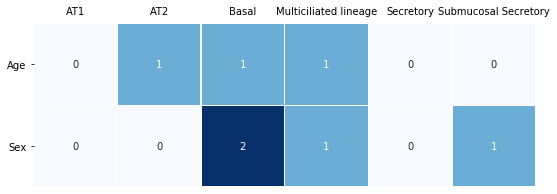

In [45]:
gene_mask = (res_summary_lvl3['gene'] == 'ACE2')
ct_mask = (res_summary_lvl3['cell_identity'].isin(['AT1', 'AT2', 'Basal', 'Multiciliated lineage', 'Secretory', 'Submucosal Secretory']))

ace2_holdout_res = res_summary_lvl3.loc[(gene_mask & ct_mask)][[('holdout_dataset_dis',''), ('covariate',''), ('cell_identity','')]].pivot(index='covariate', columns='cell_identity')

ace2_holdout_res.columns = ace2_holdout_res.columns.get_level_values(2)
ace2_holdout_res.index = ['Age', 'Sex']

rcParams['figure.figsize'] = (9,3)
p1 = sns.heatmap(ace2_holdout_res, cbar=False, cmap='Blues', annot=True, linewidths=.5)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
p1.set_yticklabels(ace2_holdout_res.index, rotation=0)
plt.ylabel('')
plt.xlabel('')
plt.savefig(folder+'/'+output_folder+de_output_base+'_annlvl3_ace2_dataset_disagreements.pdf', dpi=300, bbox_inches='tight')
plt.show()
rcParams['figure.figsize'] = (8,8)

[Text(0, 0.5, 'Age'), Text(0, 1.5, 'Sex')]

Text(24.0, 0.5, '')

Text(0.5, 6.0, '')

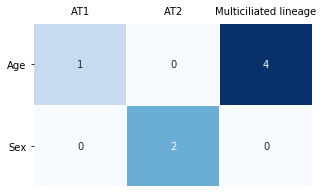

In [46]:
gene_mask = (res_summary_lvl3['gene'] == 'TMPRSS2')
ct_mask = (res_summary_lvl3['cell_identity'].isin(['AT1', 'AT2', 'Multiciliated lineage']))

ace2_holdout_res = res_summary_lvl3.loc[(gene_mask & ct_mask)][[('holdout_dataset_dis',''), ('covariate',''), ('cell_identity','')]].pivot(index='covariate', columns='cell_identity')

ace2_holdout_res.columns = ace2_holdout_res.columns.get_level_values(2)
ace2_holdout_res.index = ['Age', 'Sex']

rcParams['figure.figsize'] = (5,3)
p1 = sns.heatmap(ace2_holdout_res, cbar=False, cmap='Blues', annot=True, linewidths=.5)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
p1.set_yticklabels(ace2_holdout_res.index, rotation=0)
plt.ylabel('')
plt.xlabel('')
plt.savefig(folder+'/'+output_folder+de_output_base+'_annlvl3_tmprss2_dataset_disagreements.pdf', dpi=300, bbox_inches='tight')
plt.show()
rcParams['figure.figsize'] = (8,8)

[Text(0, 0.5, 'Age'), Text(0, 1.5, 'Sex')]

Text(33.0, 0.5, '')

Text(0.5, 6.0, '')

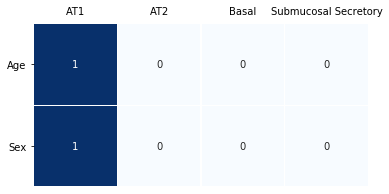

In [47]:
gene_mask = (res_summary_lvl3['gene'] == 'CTSL')
ct_mask = (res_summary_lvl3['cell_identity'].isin(['AT1', 'AT2', 'Basal', 'Submucosal Secretory']))

ace2_holdout_res = res_summary_lvl3.loc[(gene_mask & ct_mask)][[('holdout_dataset_dis',''), ('covariate',''), ('cell_identity','')]].pivot(index='covariate', columns='cell_identity')

ace2_holdout_res.columns = ace2_holdout_res.columns.get_level_values(2)
ace2_holdout_res.index = ['Age', 'Sex']

rcParams['figure.figsize'] = (6,3)
p1 = sns.heatmap(ace2_holdout_res, cbar=False, cmap='Blues', annot=True, linewidths=.5)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
p1.set_yticklabels(ace2_holdout_res.index, rotation=0)
plt.ylabel('')
plt.xlabel('')
plt.savefig(folder+'/'+output_folder+de_output_base+'_annlvl3_ctsl_dataset_disagreements.pdf', dpi=300, bbox_inches='tight')
plt.show()
rcParams['figure.figsize'] = (8,8)

# Store results

In [54]:
res_summary_lvl2.columns = ['_'.join(col).strip('_') for col in res_summary_lvl2.columns.values]
res_summary_lvl3.columns = ['_'.join(col).strip('_') for col in res_summary_lvl3.columns.values]

In [55]:
res_summary_lvl2.to_csv(folder+'/'+output_folder+de_output_base+'_lvl2_summary.csv')
full_res_lvl2_glm.to_csv(folder+'/'+output_folder+de_output_base+'_lvl2_full.csv')

In [56]:
res_summary_lvl3.to_csv(folder+'/'+output_folder+de_output_base+'_lvl3_summary.csv')
full_res_lvl3_glm.to_csv(folder+'/'+output_folder+de_output_base+'_lvl3_full.csv')